# Neural Style Transfer (NST)
_Auther: Esraa Madi_


##**Overview:**

After generating our symbol using GANs model, we will apply a traditional theme on that symbol like Shma8 theme or arabic writes.
---






In [1]:
# import libraries --> system , plotting
import numpy as np
from io import BytesIO
import os
from PIL import Image
from IPython.display import  display
import matplotlib.pyplot as plt

# import libraries --> load files
from google.colab import drive
import requests

# import libraries --> model
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [0]:
###define some paramters

epochs = 10

# Image dimentions, colors(channels)
channels = 3
image_size = 500

# define some weights
imagenet_mean_rgb_values = [123.68, 116.779, 103.939]
content_weight = 0.02
style_weight = 4.5
total_variation_weight = 0.995
total_variation_loss_factor = 1.25

##**Image and Theme Loading:**

In [0]:
# Set some paths
r_image_path = "/content/generated_images/R.png"
styled_image_path = "/content/styled_images"

# we will use 2 themes:
# 1. Arabic letters
theme1_image_path = "https://www.abouther.com/sites/default/files/2018/06/12/main_shutterstock_282667175.jpg"
# 2. Saudi shma8
theme2_image_path = "https://i.pinimg.com/originals/49/55/24/4955249f43351c87707b8fe039793481.jpg"

In [4]:
# Do google driver authorization step
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


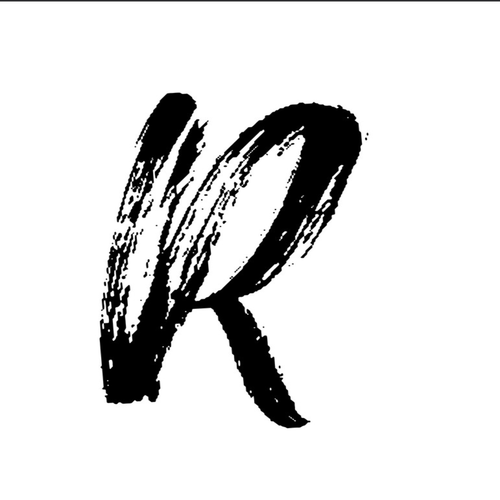

In [59]:
# Read generated image
r_image = Image.open(r_image_path).convert('RGB')
r_image = r_image.resize((image_size, image_size), Image.ANTIALIAS)
r_image

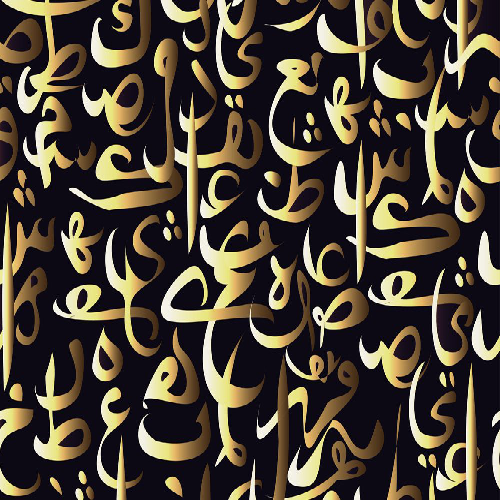

In [60]:
# Read theme image 
style1_image = Image.open(BytesIO(requests.get(theme1_image_path).content))
style1_image = style1_image.resize((image_size, image_size))
style1_image

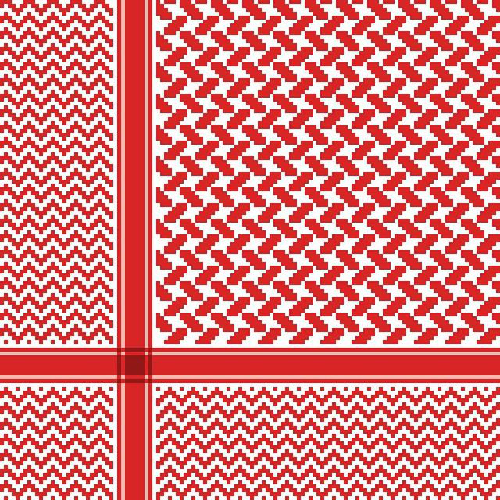

In [61]:
style2_image = Image.open(BytesIO(requests.get(theme2_image_path).content))
style2_image = style2_image.resize((image_size, image_size))
style2_image

##**Modeling (NST):**

### Image Preprocessing:

In [0]:
# Data normalization and reshaping from RGB to BGR
# we will do 2 steps:
# 1- it substracts the average r,g and b values as it was done by the people who created imagenet vgg16 model 
# 2- it changes the order of the channels from rgb to bgr 
# (I believe because the software used by the Imagenet competitors uses
#  OpenCV to load images which uses BGR as the default channel order).

In [0]:
# First: input image
input_image_array = np.asarray(r_image, dtype="float32")
input_image_array = np.expand_dims(input_image_array, axis=0)

#substracts the average
input_image_array[:, :, :, 0] -= imagenet_mean_rgb_values[2]
input_image_array[:, :, :, 1] -= imagenet_mean_rgb_values[1]
input_image_array[:, :, :, 2] -= imagenet_mean_rgb_values[0]

#rotate image colors (BGR -> RGB)
input_image_array = input_image_array[:, :, :, ::-1]

In [130]:
# Second: style images
# 1. Arabic letters style
style1_image_array = np.asarray(style1_image, dtype="float32")
style1_image_array = np.expand_dims(style1_image_array, axis=0)
style1_image_array[:, :, :, 0] -= imagenet_mean_rgb_values[2]
style1_image_array[:, :, :, 1] -= imagenet_mean_rgb_values[1]
style1_image_array[:, :, :, 2] -= imagenet_mean_rgb_values[0]
style1_image_array = style1_image_array[:, :, :, ::-1]

# 2. Shma8 style
style2_image_array = np.asarray(style2_image, dtype="float32")
style2_image_array = np.expand_dims(style2_image_array, axis=0)
style2_image_array[:, :, :, 0] -= imagenet_mean_rgb_values[2]
style2_image_array[:, :, :, 1] -= imagenet_mean_rgb_values[1]
style2_image_array[:, :, :, 2] -= imagenet_mean_rgb_values[0]
style2_image_array = style2_image_array[:, :, :, ::-1]


ValueError: ignored

### NST Model:

NST model generates images that combines the style or texture of some theme image, and the elements or content from a different one.

In [0]:
# set input images for model
content_image = backend.variable(input_image_array)
style1_image = backend.variable(style1_image_array)
style2_image = backend.variable(style2_image_array)
combination_image = backend.placeholder((1, image_size, image_size, 3))

In [0]:
# Create path for saving images
images_path = 'styled_images'
if images_path != None and not os.path.isdir(images_path):
    os.mkdir(images_path)

In [0]:
# declare some functions

def content_loss(content, combination):
    # Function to calculate how much the feature map of the generated image 
    # differs from the feature map of the source image
    # Inputs:
    #       - content: Tensor, feature map of the source image
    #       - combination: Tensor,feature map of the generated image
    # Return:
    #       - content error
    return backend.sum(backend.square(combination - content))

In [0]:
def gram_matrix(x):
    # Function to measures the cross-correlation among different filters for a given layer X
    # Input:
    #       - X: Tensor
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [0]:
def compute_style_loss(style, combination):
    # Function to calculate how much the generated image 
    # differs from the style image in term of style reconstruction
    # Inputs:
    #       - style: Tensor, feature map of the style image
    #       - combination: Tensor,feature map of the generated image
    # Return:
    #       - style error
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = image_size * image_size
    return backend.sum(backend.square(style - combination)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
def total_variation_loss(x):
    # Function to encourage smoothness in the image trying to reduce variation among the neighboring pixel values.
    # Inputs:
    #       - x: image with pixels
    # Return:
    #       - number, total variation loss.
    a = backend.square(x[:, :image_size-1, :image_size-1, :] - x[:, 1:, :image_size-1, :])
    b = backend.square(x[:, :image_size-1, :image_size-1, :] - x[:, :image_size-1, 1:, :])
    return backend.sum(backend.pow(a + b, total_variation_loss_factor))

In [0]:
# load VGG16 pretrained model
input_tensor = backend.concatenate([content_image,style1_image,combination_image], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)

layers = dict([(layer.name, layer.output) for layer in model.layers])

# Get content loss
content_layer = "block2_conv2"
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

In [139]:
loss = backend.variable(0.)
loss += content_weight * content_loss(content_image_features, combination_features)

# Get style loss
style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (style_weight / len(style_layers)) * style_loss

# Get variation loss
loss += total_variation_weight * total_variation_loss(combination_image)



outputs = [loss]
outputs += backend.gradients(loss, combination_image)



In [0]:
def evaluate_loss_and_gradients(x):
    x = x.reshape((1, image_size, image_size, channels))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

Iteration 0 completed with loss 422994542592
Iteration 1 completed with loss 211702349824
Iteration 2 completed with loss 162381627392
Iteration 3 completed with loss 139666227200
Iteration 4 completed with loss 124748726272
Iteration 5 completed with loss 114485403648
Iteration 6 completed with loss 107015495680
Iteration 7 completed with loss 101251424256
Iteration 8 completed with loss 96638115840
Iteration 9 completed with loss 92600819712


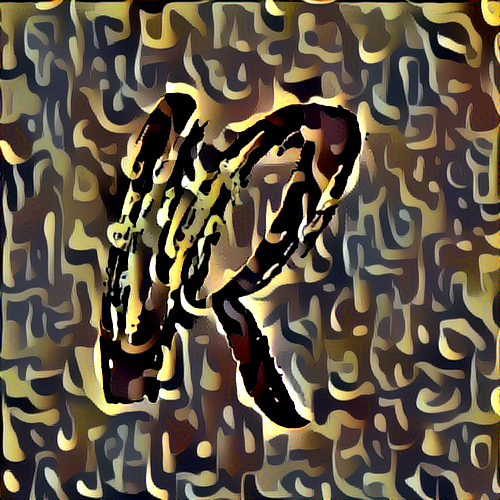

In [119]:
x = np.random.uniform(0, 255, (1, image_size, image_size, 3)) - 128.

for i in range(epochs):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
x = x.reshape((image_size, image_size, channels))
x = x[:, :, ::-1]
x[:, :, 0] += imagenet_mean_rgb_values[2]
x[:, :, 1] += imagenet_mean_rgb_values[1]
x[:, :, 2] += imagenet_mean_rgb_values[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(styled_image_path)
output_image

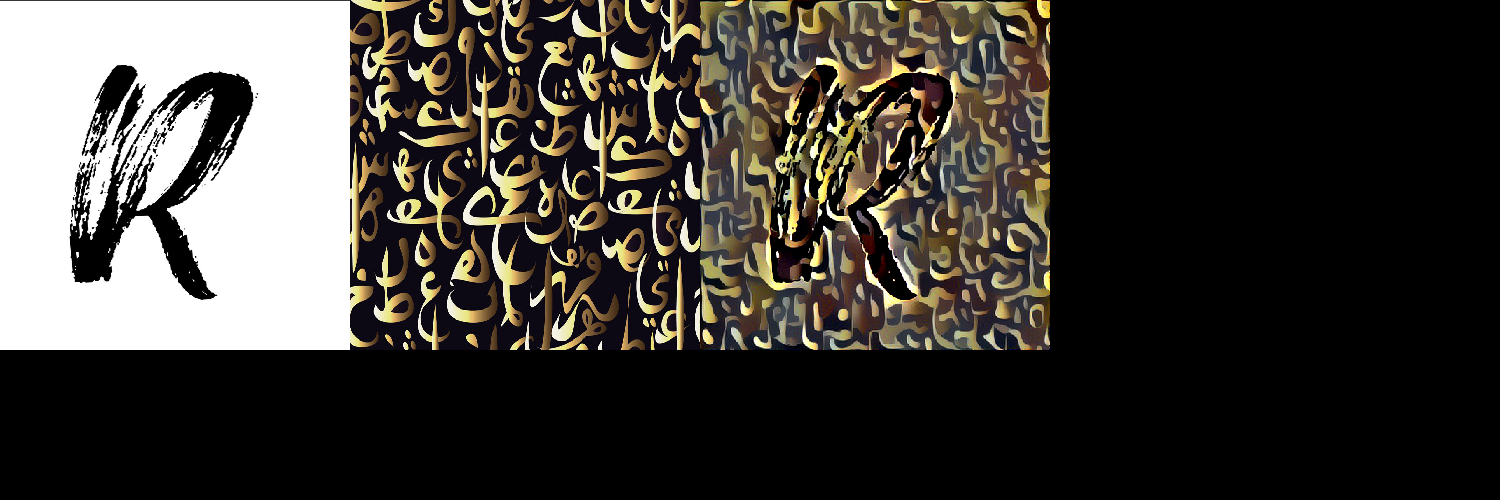

In [128]:
# Visualizing combined results
combined = Image.new("RGB", (image_size*3, image_size))
x_offset = 0
for image in map(Image.open, [r_image_path, BytesIO(requests.get(theme1_image_path).content) , styled_image_path]):
    combined.paste(image.resize((350, 350)), (x_offset, 0))
    x_offset += 350
combined

Iteration 0 completed with loss 685751795712
Iteration 1 completed with loss 401799118848
Iteration 2 completed with loss 326964740096
Iteration 3 completed with loss 299721949184
Iteration 4 completed with loss 285478092800
Iteration 5 completed with loss 275258408960
Iteration 6 completed with loss 268137938944
Iteration 7 completed with loss 262712524800
Iteration 8 completed with loss 258568192000
Iteration 9 completed with loss 255198691328


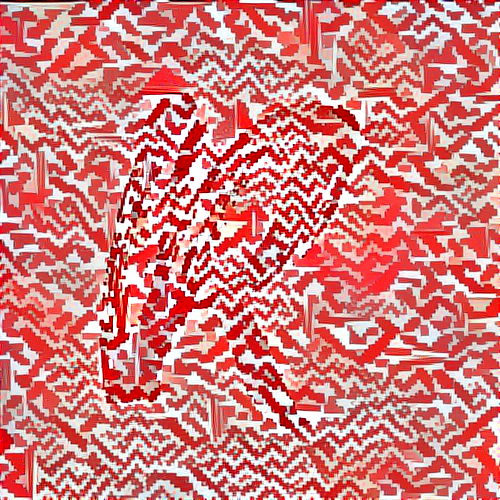

In [141]:
x = np.random.uniform(0, 255, (1, image_size, image_size, 3)) - 128.

for i in range(epochs):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
x = x.reshape((image_size, image_size, channels))
x = x[:, :, ::-1]
x[:, :, 0] += imagenet_mean_rgb_values[2]
x[:, :, 1] += imagenet_mean_rgb_values[1]
x[:, :, 2] += imagenet_mean_rgb_values[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(styled_image_path)
output_image

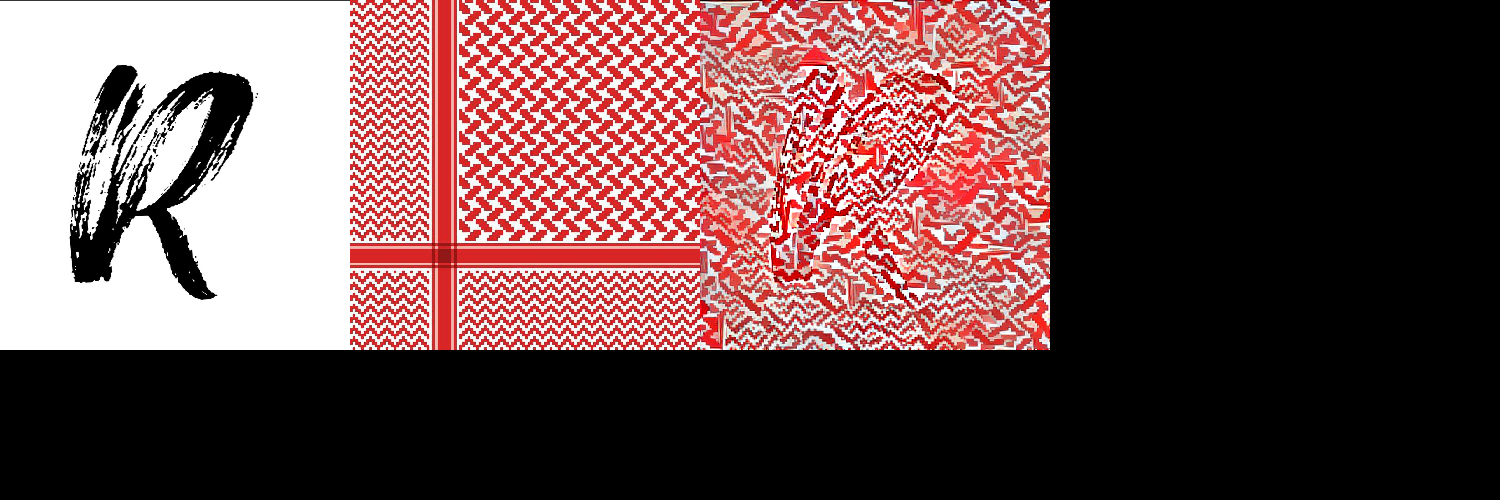

In [142]:
# Visualizing combined results
combined = Image.new("RGB", (image_size*3, image_size))
x_offset = 0
for image in map(Image.open, [r_image_path, BytesIO(requests.get(theme2_image_path).content) , styled_image_path]):
    combined.paste(image.resize((350, 350)), (x_offset, 0))
    x_offset += 350
combined